# Table E4

## Pearson’s correlation between image-expression axes (IEAs) and COPD-related characteristics and health outcomes, measured on 1,527 subjects from another subset of the COPDGene dataset that had not been used for model training. 

In [1]:
import numpy as np
import sys
sys.path.append("../../src/")
import utility
import pandas as pd

from matplotlib import pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import ttest_ind

from scipy.stats import kruskal
from statsmodels.stats.proportion import proportions_chisquare

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib

import statsmodels.api as sm

from scipy import stats

import pandas as pd

import math


In [2]:
df_IEA_train = pd.read_csv("../../output/IEA_train.csv").set_index("sid")
df_IEA_test = pd.read_csv("../../output/IEA_test.csv").set_index("sid")

df_IEA_P2 = pd.read_csv("../../output/IEA_P2.csv").set_index("sid")



In [3]:
sid_used = [iii for iii in df_IEA_P2.index if iii not in df_IEA_train.index and iii not in df_IEA_test.index]

df_IEA = df_IEA_P2[ df_IEA_P2.index.isin(sid_used) ]

In [4]:
df = utility.load_data()

df_used = pd.merge(df, df_IEA, left_index = True, right_index = True)

/ocean/projects/asc170022p/juc91/anaconda/lib/python3.8/site-packages/pandas/core/series.py:1020: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
/ocean/projects/asc170022p/juc91/anaconda/lib/python3.8/site-packages/pandas/core/series.py:1020: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
/ocean/projects/asc170022p/juc91/anaconda/lib/python3.8/site-packages/pandas/core/series.py:1020: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas

In [5]:
covariances = [
               "BMI_P2", "ATS_PackYears_P2",
               "FEV1pp_utah_P2", "FEV1_FVC_utah_P2", 
               "SGRQ_scoreTotal_P2", "MMRCDyspneaScor_P2", 
               "distwalked_P2", 
               "Perc15_Insp_Thirona_P2", "pctEmph_Thirona_P2", "pctGasTrap_Thirona_P2", "Pi10_Thirona_P2", 
               "WallAreaPct_seg_Thirona_P2", "perc15_ratio", 
               "delta_FEV1pp_P2P3", "delta_FEV1FVC_P2P3",
           ] 


In [6]:
# Change the variable names
cov_label = [iii.replace("Frequent_Exacerbator_P2", "Frequent Exacerbator (History)")\
             .replace("Frequent_Exacerbator_P3", "Frequent Exacerbator (Future)")\
             .replace("smoking_status_P2", "%Current Smoker").replace("_P2", "").replace("P3", "")\
             .replace("ATS_", "").replace("_Thirona", "").replace("FEV1pp_utah", "FEV$_1$%predicted")\
             .replace("FEV1_FVC_utah", "FEV$_1$/FVC").replace("distwalked", "6-Minute-Walk Distance").replace("pctEmph", "%Emphysema at -950HU")\
             .replace("Perc15_Insp", "perc15").replace("pctGasTrap", "%Gas Trapping").replace("gender", "Gender, %females")\
             .replace("race", "Race, %African-American").replace("PackYears", "Pack Years").replace("WallAreaPct_seg", "%WA segmental")\
             .replace("BMI", "Body Mass Index (BMI)").replace("Pi10", "Pi10").replace("SGRQ_scoreTotal", "SGRQ Total Score")\
             .replace("MMRCDyspneaScor", "mMRC Dyspnea Score")\
             .replace("FEV1pp", "FEV$_1$%predicted").replace("FEV1FVC", "FEV$_1$/FVC").replace("WApct", "%WA segmental")\
             .replace("delta_", "$\Delta$")\
             .replace("perc15_ratio", "$Q_{perc15_{peel-core}}$")
             for iii in covariances]

# Computing the correlation coefficients

In [7]:
res_text = []

for ccc in covariances + ["IEA0", "IEA1"]:
    row = []
    for iii in ["IEA0", "IEA1"]:
        
        x1 = df_used[iii]
        x2 = df_used[ccc]
        
        idx = np.bitwise_and(~np.isnan(x1), ~np.isnan(x2))
        
        r,p = pearsonr(df_used[iii][idx], df_used[ccc][idx])
        
        row.append( "{:.2f}".format(r) )
        if p < .05:
            row[-1] += "*"
        if p < .01:
            row[-1] += "*"
        if p < .001:
            row[-1] += "*"
        
    res_text.append(row)

# Generating the Table

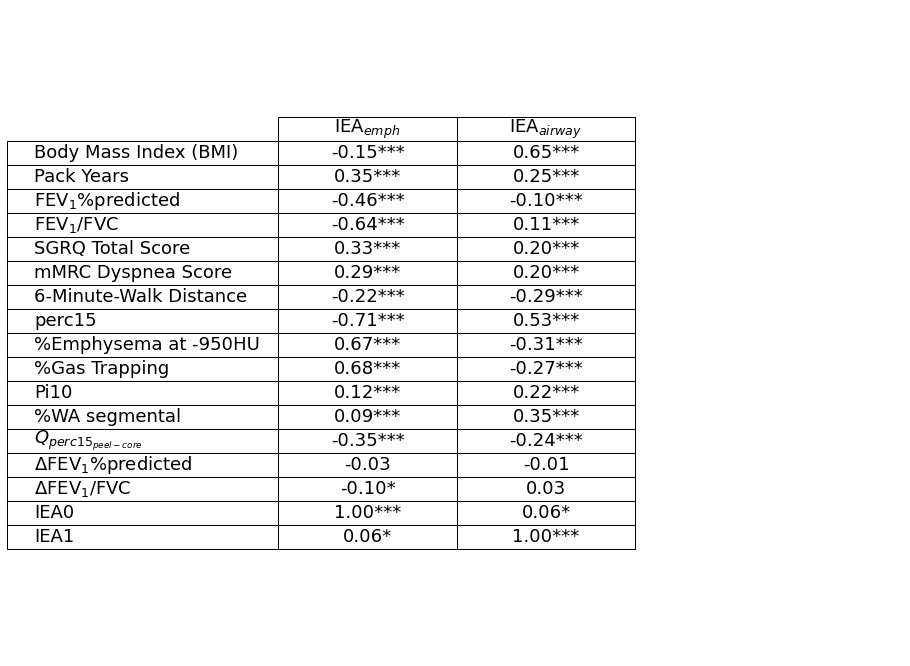

In [8]:
fig, ax = plt.subplots(figsize=(16,12))

the_table=plt.table(cellText=res_text, rowLabels=cov_label  + ["IEA0", "IEA1"], 
                    colLabels = ["IEA$_{emph}$", "IEA$_{airway}$"],
                     colWidths = [.1]*len(res_text), loc='center', fontsize = 50, cellLoc = "center"
                   )

plt.axis('off')

the_table.auto_set_font_size(False)
the_table.set_fontsize(18)
the_table.scale(2, 2)